In [ ]:
#: Import necessary libraries
import os
import pandas as pd
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, skew, kurtosis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

print(" Libraries imported successfully!")


✅ Libraries imported successfully!


In [ ]:

weather_dir = r"D:\dataScience-Assignments\raw\weather_raw_data"
electricity_dir = r"D:\dataScience-Assignments\raw\electricity_raw_data"
output_file = r"D:\dataScience-Assignments\final_cleaned_data.csv"

print(" File paths set!")


 File paths set!


In [ ]:
#  Function to load weather data
def load_weather_data(weather_dir):
    weather_data = []
    
    for file in glob.glob(os.path.join(weather_dir, "*.csv")):
        df = pd.read_csv(file, parse_dates=['date'])
        df.rename(columns={'date': 'timestamp', 'temperature_2m': 'temperature'}, inplace=True)
        weather_data.append(df)

    return pd.concat(weather_data, ignore_index=True) if weather_data else pd.DataFrame()

print(" Weather data loader function defined.")


 Weather data loader function defined.


In [ ]:
#  Function to load electricity data
def load_electricity_data(electricity_dir):
    electricity_data = []
    
    for file in glob.glob(os.path.join(electricity_dir, "*.json")):
        with open(file, "r", encoding="utf-8") as f:
            data = json.load(f)

        if "response" in data and "data" in data["response"]:
            for entry in data["response"]["data"]:
                electricity_data.append({
                    "timestamp": entry["period"],
                    "zone": entry["subba-name"],
                    "electricity_demand": float(entry["value"])
                })

    df = pd.DataFrame(electricity_data)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y-%m-%dT%H")
    
    return df

print(" Electricity data loader function defined.")


 Electricity data loader function defined.


In [ ]:
#  Data preprocessing function
def preprocess_data(weather_df, electricity_df):
    weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'], utc=True).dt.tz_convert(None)
    electricity_df['timestamp'] = pd.to_datetime(electricity_df['timestamp'], utc=True).dt.tz_convert(None)

    merged_df = pd.merge(weather_df, electricity_df, on='timestamp', how='inner')

    # Handle Missing Values
    merged_df.ffill(inplace=True)  
    merged_df.drop_duplicates(inplace=True)

    # Feature Engineering
    merged_df['hour'] = merged_df['timestamp'].dt.hour
    merged_df['day_of_week'] = merged_df['timestamp'].dt.dayofweek
    merged_df['month'] = merged_df['timestamp'].dt.month

    merged_df.drop(columns=['timestamp'], inplace=True)

    return merged_df

print(" Data preprocessing function defined.")


 Data preprocessing function defined.


In [ ]:
# Exploratory Data Analysis (EDA)
def perform_eda(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = df[numeric_cols].astype(float)

    print("\nStatistical Summary:\n", df[numeric_cols].describe())
    print("\nSkewness:\n", df[numeric_cols].apply(skew))
    print("\nKurtosis:\n", df[numeric_cols].apply(kurtosis))

    # Correlation Heatmap
    plt.figure(figsize=(8, 5))
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

    # Time Series Decomposition
    result = seasonal_decompose(df['electricity_demand'], model='additive', period=24)
    result.plot()
    plt.show()

    # Stationarity Test
    adf_test = adfuller(df['electricity_demand'])
    print(f"ADF Statistic: {adf_test[0]}")
    print(f"p-value: {adf_test[1]}")
    print("Stationary" if adf_test[1] < 0.05 else "Non-Stationary")

print(" EDA function defined.")


📊 EDA function defined.


In [ ]:
#  Outlier detection
def detect_outliers(df):
    df['z_score'] = zscore(df['electricity_demand'])
    df['outlier_z'] = df['z_score'].abs() > 3

    Q1 = df['electricity_demand'].quantile(0.25)
    Q3 = df['electricity_demand'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df['outlier_iqr'] = (df['electricity_demand'] < lower_bound) | (df['electricity_demand'] > upper_bound)

    return df

print(" Outlier detection function defined.")


 Outlier detection function defined.


In [ ]:
# Train regression model
def train_regression(df):
    features = ['hour', 'day_of_week', 'month', 'temperature']
    X = df[features]
    y = df['electricity_demand']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("\nModel Evaluation:")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred)}")
    print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print(f"R² Score: {r2_score(y_test, y_pred)}")

print(" Regression model function defined.")


 Regression model function defined.


 Processed data saved at D:\dataScience-Assignments\final_cleaned_data.csv

Statistical Summary:
          temperature  electricity_demand           hour    day_of_week  \
count  289531.000000       289531.000000  289531.000000  289531.000000   
mean       11.346059         1556.937606      11.502223       2.998708   
std         8.095719         1455.568629       6.921747       2.001674   
min       -10.491500          168.000000       0.000000       0.000000   
25%         5.008500          696.000000       6.000000       1.000000   
50%        10.808500         1120.000000      12.000000       3.000000   
75%        17.408500         1725.000000      18.000000       5.000000   
max        37.708500        10830.000000      23.000000       6.000000   

               month  
count  289531.000000  
mean        6.517648  
std         3.450933  
min         1.000000  
25%         4.000000  
50%         7.000000  
75%        10.000000  
max        12.000000  

Skewness:
 temperature     

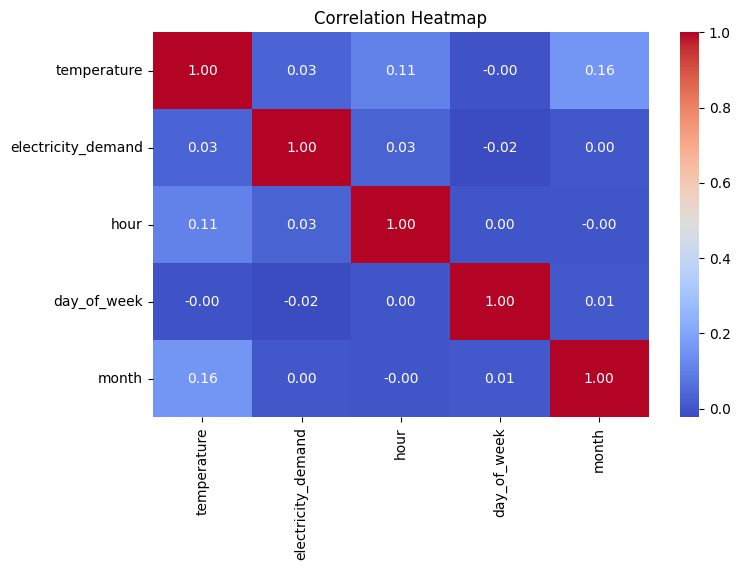

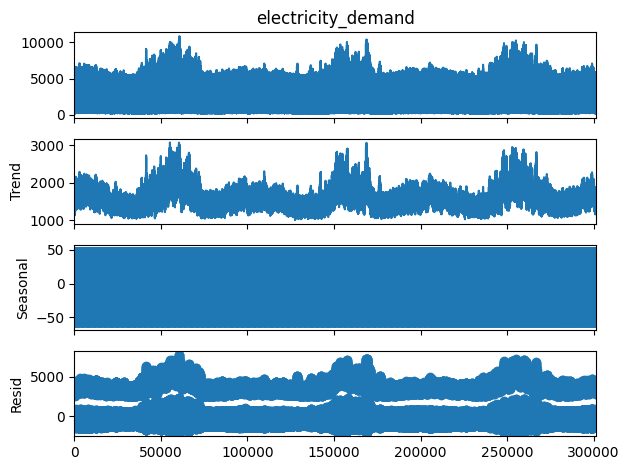

ADF Statistic: -24.35698564097059
p-value: 0.0
Stationary

Model Evaluation:
Mean Squared Error (MSE): 2055280.33594627
Root Mean Squared Error (RMSE): 1433.6248937383411
R² Score: 0.00234639180822771


In [9]:
# Run the pipeline
weather_df = load_weather_data(weather_dir)
electricity_df = load_electricity_data(electricity_dir)

if not weather_df.empty and not electricity_df.empty:
    final_df = preprocess_data(weather_df, electricity_df)
    final_df.to_csv(output_file, index=False)
    print(f" Processed data saved at {output_file}")

    perform_eda(final_df)
    final_df = detect_outliers(final_df)
    train_regression(final_df)

else:
    print(" No data processed. Check input directories.")
